In [1]:
import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
BATCH_SIZE = 64

In [3]:
from dataset import SmashVODFrameDataset

frame_df = pd.read_csv("records.csv")
all_characters = sorted(
    pd.concat([frame_df["p1_character"], frame_df["p2_character"]]).unique()
)
character_map = {char: i for i, char in enumerate(all_characters)}

vod_dataset = SmashVODFrameDataset(
    frame_df,
    ".",
    character_map,
    transform=transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((224, 398)),
            transforms.ToTensor(),
        ]
    ),
)

lengths = [round(len(vod_dataset) * 0.8), round(len(vod_dataset) * 0.2)]
print(lengths, sum(lengths), len(vod_dataset))
train_set, val_set = torch.utils.data.random_split(vod_dataset, lengths)

frame_datasets = {"train": train_set, "val": val_set}

dataloaders = {
    x: torch.utils.data.DataLoader(
        frame_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
    )
    for x, frame_dataset in frame_datasets.items()
}
dataset_sizes = {x: len(frame_dataset) for x, frame_dataset in frame_datasets.items()}

# pylint:disable=no-member
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[12137, 3034] 15171 15171


In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            progress = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                progress += len(inputs)
                if progress % (BATCH_SIZE * 20) == 0:
                    print(progress, "/", dataset_sizes[phase])
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    preds = outputs.round()
                    preds -= labels
                    num_incorrect = torch.sum(preds.abs(), dim=1)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(
                    torch.Tensor([len(character_map)]).cuda() - num_incorrect
                )
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
model = models.vgg11(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(vod_dataset.character_map.keys())),
    nn.Sigmoid(),
)
model = model.to(device)

criterion = nn.BCELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

torch.save(model_ft.state_dict(), "best_model.pt")

Epoch 0/24
----------
1280 / 12137
2560 / 12137
3840 / 12137
5120 / 12137
6400 / 12137
7680 / 12137
8960 / 12137
10240 / 12137
11520 / 12137
train Loss: 0.4040 Acc: 15.3239
1280 / 3034
2560 / 3034
val Loss: 0.2789 Acc: 16.1101

Epoch 1/24
----------
1280 / 12137
2560 / 12137
3840 / 12137
5120 / 12137
6400 / 12137
7680 / 12137
8960 / 12137
10240 / 12137
11520 / 12137
train Loss: 0.2812 Acc: 16.0994
1280 / 3034
2560 / 3034
val Loss: 0.2719 Acc: 16.1315

Epoch 2/24
----------
1280 / 12137
2560 / 12137
3840 / 12137
5120 / 12137
6400 / 12137
7680 / 12137
8960 / 12137
10240 / 12137
11520 / 12137
train Loss: 0.2771 Acc: 16.1039
1280 / 3034
2560 / 3034
val Loss: 0.2703 Acc: 16.1246

Epoch 3/24
----------
1280 / 12137
2560 / 12137
3840 / 12137
5120 / 12137
6400 / 12137
7680 / 12137
8960 / 12137
10240 / 12137
11520 / 12137
train Loss: 0.2753 Acc: 16.1095
1280 / 3034
2560 / 3034
val Loss: 0.2695 Acc: 16.1450

Epoch 4/24
----------
1280 / 12137
2560 / 12137
3840 / 12137
5120 / 12137
6400 / 12137
7

In [7]:
def readable_labels(tensor):
    reverse_character_map = {v:k for k,v in character_map.items()}
    return [reverse_character_map[i] for i in range(len(tensor)) if tensor[i] != 0]

Expected = ['Falco', 'Jigglypuff']
tensor([0.2618, 0.0079, 0.0153, 0.2683, 0.4467, 0.0197, 0.0631, 0.1375, 0.0084,
        0.0463, 0.0072, 0.2423, 0.0094, 0.1509, 0.0454, 0.0645, 0.1738, 0.0289],
       device='cuda:0', grad_fn=<SelectBackward>)
Actual = []


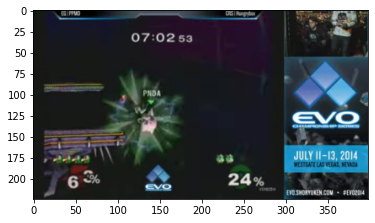

In [8]:
%matplotlib inline
print(character_)
reverse_character_map = {v: k for k, v in character_map.items()}
image_tensor, label_tensor = frame_datasets["val"][0]
to_pil = torchvision.transforms.ToPILImage()
image = to_pil(image_tensor)
plt.imshow(image)
print("Expected =", readable_labels(label_tensor))

predictions_tensor = model_ft(image_tensor.cuda().unsqueeze(0))[0]
print(predictions_tensor)
print("Actual =", readable_labels(predictions_tensor.round()))